In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score, hamming_loss, confusion_matrix, make_scorer, ConfusionMatrixDisplay

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import shap
import os

# PreProcessing

In [ ]:
# ===== Load and preprocess data =====
df = pd.read_csv("spotify_emotion_feature_multi.csv")

group_cols = ["track_id", "title", "artist"]
feature_cols = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'key', 'liveness', 'loudness', 'mode', 'speechiness',
    'tempo', 'time_signature', 'valence'
]

# Aggregate features + emotion labels
df_features = df.drop_duplicates(subset=group_cols)[group_cols + feature_cols]
df_labels = df.groupby(group_cols)["emotion"].apply(list).reset_index()
df_full = pd.merge(df_features, df_labels, on=group_cols)

# Label binarization
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df_full["emotion"])
X = df_full[feature_cols]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optional PCA
use_pca = True
if use_pca:
    pca = PCA(n_components=10)
    X_train_scaled = pca.fit_transform(X_train_scaled)
    X_test_scaled = pca.transform(X_test_scaled)

# EDA

In [4]:
# 1. Continuous features summary
feature_stats = df_full[feature_cols].describe().T

# 2. Categorical: Emotion label frequency (multi-label, explode)
emotion_counts = df_full.explode("emotion")["emotion"].value_counts()
emotion_percent = emotion_counts / emotion_counts.sum()

# 3. Categorical: mode (binary), key (categorical)
mode_counts = df_full["mode"].value_counts()
mode_percent = mode_counts / mode_counts.sum()

key_counts = df_full["key"].value_counts().sort_index()
key_percent = key_counts / key_counts.sum()

# Display summary tables
print("Audio Feature Statistics:")
print(feature_stats)

print("Emotion Label Frequencies:")
print(pd.DataFrame({
    "Count": emotion_counts,
    "Proportion": emotion_percent
}))

print("Mode Distribution:")
print(pd.DataFrame({
    "Count": mode_counts,
    "Proportion": mode_percent
}))

print("Key Distribution:")
print(pd.DataFrame({
    "Count": key_counts,
    "Proportion": key_percent
}))

Audio Feature Statistics:
                    count        mean        std       min        25%  \
acousticness      39635.0    0.248638   0.308005   0.00000   0.004830   
danceability      39635.0    0.523073   0.177293   0.00000   0.398000   
energy            39635.0    0.650254   0.250822   0.00002   0.471000   
instrumentalness  39635.0    0.164308   0.299270   0.00000   0.000002   
key               39635.0    5.316311   3.559723   0.00000   2.000000   
liveness          39635.0    0.198394   0.163566   0.00882   0.095250   
loudness          39635.0   -8.816517   4.413843 -50.01400 -11.140000   
mode              39635.0    0.659266   0.473962   0.00000   0.000000   
speechiness       39635.0    0.076672   0.084309   0.00000   0.034000   
tempo             39635.0  122.075654  29.576743   0.00000  99.337498   
time_signature    39635.0    3.904075   0.398605   0.00000   4.000000   
valence           39635.0    0.486782   0.259622   0.00000   0.272000   

                        

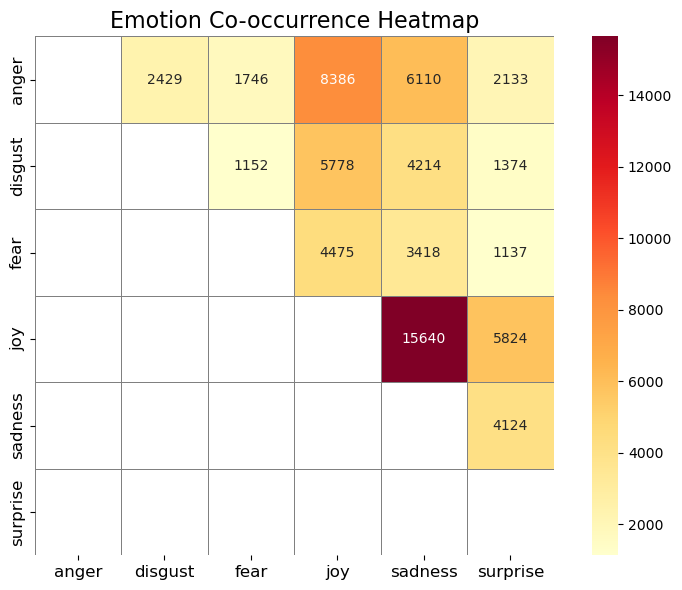

In [13]:
# Emotion Co-occurrence Matrix

# ===== Step 1: Recompute Co-occurrence Matrix =====
mlb = MultiLabelBinarizer()
y_bin = mlb.fit_transform(df_full["emotion"])
co_occurrence = np.dot(y_bin.T, y_bin)
co_occurrence_df = pd.DataFrame(co_occurrence, index=mlb.classes_, columns=mlb.classes_)

# ===== Step 2: Create Mask to Hide Lower Triangle and Diagonal =====
mask = np.tril(np.ones_like(co_occurrence_df, dtype=bool))  # lower triangle + diag = True

# ===== Step 3: Plot Upper Triangle Only =====
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    co_occurrence_df,
    mask=mask,
    annot=True,
    fmt="d",
    cmap="YlOrRd",
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar=True
)

# ===== Step 4: Increase font sizes =====
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

plt.title("Emotion Co-occurrence Heatmap", fontsize=16)
plt.tight_layout()
plt.savefig("Presentation/images/Emotion_Co_Heatmap.png", dpi=300)
plt.show()

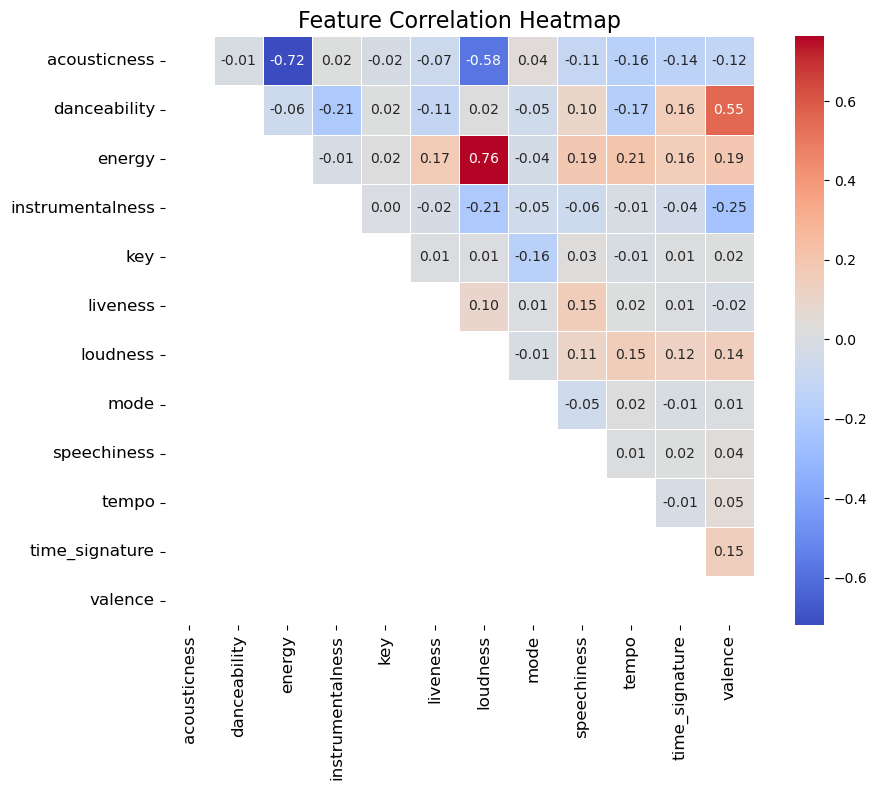

In [15]:
# Correlation Matrix
# ===== Step 1: Compute correlation matrix =====
corr = df_full[feature_cols].corr()

# ===== Step 2: Create mask for lower triangle + diagonal =====
mask = np.tril(np.ones_like(corr, dtype=bool))

# ===== Step 3: Plot upper triangle only =====
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    cbar=True,
    annot_kws={"size": 10}  
)

# ===== Step 4: Set larger font for axis labels and title =====
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title("Feature Correlation Heatmap", fontsize=16)

plt.tight_layout()
plt.savefig("Presentation/images/feature_correlation.png", dpi=300)
plt.show()


# Multilabel Evaluation Strategy (Top-K Dynamic Matching):

For each song, we dynamically set the number of predicted labels 𝑘 to be equal to the number of true labels for that sample. We then select the top-𝑘 classes from the predicted probability vector and binarize them to form the final prediction.

Evaluation is performed using micro-averaged precision, recall, and F1 score, which means every label prediction (across all samples) is treated as a separate binary decision. A correctly predicted label contributes +1 to the true positives, while incorrect predictions (either false positives or false negatives) are penalized individually.

This method ensures that predictions are fairly evaluated even when the number of true labels per sample varies, and avoids diluting the score across entire samples. It is particularly suitable for multilabel tasks with varying label cardinality.

In [ ]:
# ===== Top-K dynamic prediction =====
def get_top_k_dynamic_predictions(y_prob, y_true):
    y_pred = np.zeros_like(y_prob)
    for i in range(len(y_prob)):
        k = int(y_true[i].sum())
        if k == 0:
            continue
        topk = np.argsort(y_prob[i])[-k:]
        y_pred[i, topk] = 1
    return y_pred

# ===== Universal runner function =====
def run_model(model_name="logistic", k_dynamic=True):
    print(f"Running model: {model_name}")

    if model_name == "mlp":
        base_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
    elif model_name == "random_forest":
        base_model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_name == "knn":
        base_model = KNeighborsClassifier(n_neighbors=5)
    else:
        raise ValueError("Unsupported model")

    model = OneVsRestClassifier(base_model)
    model.fit(X_train_scaled, y_train)

    y_proba = model.predict_proba(X_test_scaled)
    y_pred = get_top_k_dynamic_predictions(y_proba, y_test)

    # Evaluation
    precision = precision_score(y_test, y_pred, average="micro")
    recall = recall_score(y_test, y_pred, average="micro")
    f1 = f1_score(y_test, y_pred, average="micro")
    exact = accuracy_score(y_test, y_pred)
    hamming = hamming_loss(y_test, y_pred)

    print(f"Micro-average metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Exact Match Accuracy: {exact:.4f}")
    print(f"Hamming Loss:         {hamming:.4f}")

    print("Per-class report:")
    print(classification_report(y_test, y_pred, target_names=mlb.classes_))

    return {
        "model": model_name,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "exact_match": exact,
        "hamming": hamming
    }


In [19]:
results = []
for model in ["mlp", "random_forest", "knn"]:
    result = run_model(model_name=model)
    results.append(result)

Running model: mlp

🔍 Micro-average metrics:
Precision: 0.6757
Recall:    0.6757
F1 Score:  0.6757
Exact Match Accuracy: 0.3627
Hamming Loss:         0.2268
Per-class report:
              precision    recall  f1-score   support

       anger       0.58      0.56      0.57      2381
     disgust       0.51      0.33      0.40      1780
        fear       0.52      0.17      0.25      1274
         joy       0.76      0.95      0.84      5445
     sadness       0.68      0.84      0.76      4265
    surprise       0.50      0.24      0.32      1484

   micro avg       0.68      0.68      0.68     16629
   macro avg       0.59      0.51      0.52     16629
weighted avg       0.65      0.68      0.64     16629
 samples avg       0.60      0.60      0.60     16629

Running model: random_forest

🔍 Micro-average metrics:
Precision: 0.6766
Recall:    0.6766
F1 Score:  0.6766
Exact Match Accuracy: 0.3667
Hamming Loss:         0.2261
Per-class report:
              precision    recall  f1-score

## F1 Score Comparison

In [ ]:
# ===== Extend run_model，add more types of averaged F1 =====
def run_model_with_f1_variants(model_name="logistic"):
    print(f"Running model: {model_name}")

    if model_name == "mlp":
        base_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
    elif model_name == "random_forest":
        base_model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_name == "knn":
        base_model = KNeighborsClassifier(n_neighbors=5)
    else:
        raise ValueError("Unsupported model")

    model = OneVsRestClassifier(base_model)
    model.fit(X_train_scaled, y_train)
    y_proba = model.predict_proba(X_test_scaled)
    y_pred = get_top_k_dynamic_predictions(y_proba, y_test)

    return {
        "model": model_name,
        "f1_micro": f1_score(y_test, y_pred, average="micro"),
        "f1_macro": f1_score(y_test, y_pred, average="macro"),
        "f1_weighted": f1_score(y_test, y_pred, average="weighted"),
    }

# ===== Run and Store =====
model_names = ["mlp", "random_forest", "knn"]
results = [run_model_with_f1_variants(name) for name in model_names]
results_df = pd.DataFrame(results)


Running model: mlp
Running model: random_forest
Running model: knn


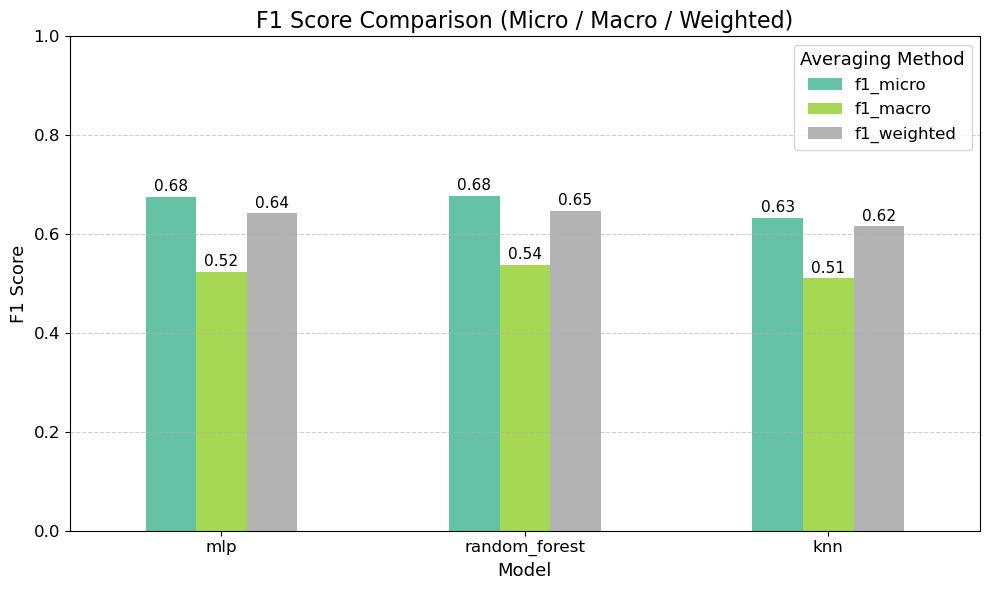

In [24]:
def plot_f1_comparison(df):
    df_plot = df.set_index("model")[["f1_micro", "f1_macro", "f1_weighted"]]
    ax = df_plot.plot(kind="bar", figsize=(10, 6), colormap="Set2", rot=0)

    # ===== Set font sizes =====
    plt.title("F1 Score Comparison (Micro / Macro / Weighted)", fontsize=16)
    plt.ylabel("F1 Score", fontsize=13)
    plt.xlabel("Model", fontsize=13)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0, 1)

    # ===== Legend styling =====
    legend = plt.legend(title="Averaging Method", fontsize=12, title_fontsize=13)

    # ===== Add value labels on top of bars =====
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=11, padding=2)

    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.savefig("Presentation/images/F1 Score Comparison.png", dpi=300)
    plt.show()

plot_f1_comparison(results_df)

# Hyperparameter Tuning

## Use Grid Search CV & OneVsRestClassifier to find the best parameters for Random Forest

In [22]:
# ===== Dynamic Top-K prediction function (based on true label count) =====

def get_top_k_dynamic_predictions(y_prob, y_true):
    """
    For each sample, predict the top-K labels, where K equals the number of true labels.
    """
    y_pred = np.zeros_like(y_prob)
    for i in range(len(y_prob)):
        k = int(y_true[i].sum())
        if k == 0:
            continue
        topk = np.argsort(y_prob[i])[-k:]
        y_pred[i, topk] = 1
    return y_pred

# ===== Define parameter grid for Random Forest =====
param_grid = {
    "estimator__n_estimators": [100, 200],
    "estimator__max_depth": [None, 10, 20],
    "estimator__min_samples_split": [2, 5],
    "estimator__min_samples_leaf": [1, 2]
}

# ===== Initialize base model =====
rf = RandomForestClassifier(random_state=42)
ovr = OneVsRestClassifier(rf)

# ===== Set up GridSearchCV =====
grid_search = GridSearchCV(
    estimator=ovr,
    param_grid=param_grid,
    scoring="f1_micro",
    cv=3,
    verbose=2,
    n_jobs=-1
)

# ===== Fit the grid search =====
print("Tuning Random Forest with GridSearchCV...")
grid_search.fit(X_train_scaled, y_train)

# ===== Evaluate best model =====
best_model = grid_search.best_estimator_
y_proba = best_model.predict_proba(X_test_scaled)
y_pred = get_top_k_dynamic_predictions(y_proba, y_test)

# ===== Step 6: Print evaluation metrics =====
precision = precision_score(y_test, y_pred, average="micro")
recall = recall_score(y_test, y_pred, average="micro")
f1 = f1_score(y_test, y_pred, average="micro")
exact = accuracy_score(y_test, y_pred)
hamming = hamming_loss(y_test, y_pred)

print("Best Parameters Found:")
print(grid_search.best_params_)

print("Evaluation of Best Model:")
print(f"Micro Precision: {precision:.4f}")
print(f"Micro Recall:    {recall:.4f}")
print(f"Micro F1 Score:  {f1:.4f}")
print(f"Exact Match Accuracy: {exact:.4f}")
print(f"Hamming Loss:         {hamming:.4f}")

print("Per-class report:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))


Tuning Random Forest with GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END estimator__max_depth=None, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100; total time=  49.4s
[CV] END estimator__max_depth=None, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100; total time=  49.7s
[CV] END estimator__max_depth=None, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100; total time=  50.0s
[CV] END estimator__max_depth=None, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100; total time=  50.0s
[CV] END estimator__max_depth=None, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100; total time=  50.4s
[CV] END estimator__max_depth=None, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100; total time=  50.6s
[CV] END estima

In [23]:
best_rf = grid_search.best_estimator_
best_rf

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=20,
                                                     n_estimators=200,
                                                     random_state=42))

# Feature Importance

| Model             | Method to extract importance                                                     |
| ----------------- | -------------------------------------------------------------------------------- |
| **Random Forest** | `model.estimators_[i].feature_importances_` per class (label)                    |
| **MLP**           | No direct interpretation → use **SHAP**  |
| **KNN**           | No direct interpretation → use **permutation importance**                             |


In [ ]:
# ========== Step 0: Re-scale raw features without PCA ==========
scaler_raw = StandardScaler()
X_train_scaled_raw = scaler_raw.fit_transform(X_train)
X_test_scaled_raw = scaler_raw.transform(X_test)

# ========== Step 1: Compute global (mean) permutation importance ==========
def get_global_multilabel_importance(ovr_model, X, Y, feature_names):
    """
    Averages permutation importance across all binary estimators inside OneVsRestClassifier.
    """
    all_scores = []

    for i in range(Y.shape[1]):
        estimator = ovr_model.estimators_[i]
        result = permutation_importance(
            estimator,
            X,
            Y[:, i],
            n_repeats=5,
            scoring="f1",
            random_state=42,
            n_jobs=-1
        )
        all_scores.append(result.importances_mean)

    avg_importance = np.mean(all_scores, axis=0)
    return dict(zip(feature_names, avg_importance))

# ========== Step 2: Compute per-label permutation importance ==========
def get_per_label_permutation_importance(ovr_model, X, Y, feature_names):
    """
    Runs permutation importance for each individual binary estimator inside OneVsRestClassifier.
    Returns: dict[label_name -> {feature: importance}]
    """
    label_names = mlb.classes_
    results = {}

    for i, label in enumerate(label_names):
        estimator = ovr_model.estimators_[i]  # binary model for this label
        result = permutation_importance(
            estimator,
            X,
            Y[:, i],
            n_repeats=5,
            scoring="f1",
            random_state=42,
            n_jobs=-1
        )
        results[label] = dict(zip(feature_names, result.importances_mean))
    
    return results


# ========== Summary ==========
# Now have the following dictionaries:
# Global importance (per feature, averaged over all labels):
# - knn_global_importance
# - rf_global_importance
# - mlp_global_importance

# Per-label importance (per feature for each emotion):
# - knn_per_label_importance
# - rf_per_label_importance
# - mlp_per_label_importance

In [27]:
# ========== Step 3: KNN ==========
knn_model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5))
knn_model.fit(X_train_scaled_raw, y_train)

knn_global_importance = get_global_multilabel_importance(knn_model, X_train_scaled_raw, y_train, feature_cols)
knn_per_label_importance = get_per_label_permutation_importance(knn_model, X_train_scaled_raw, y_train, feature_cols)

# ========== Step 4: Random Forest ==========
rf_model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
rf_model.fit(X_train_scaled_raw, y_train)

# Global: use built-in importance
rf_global_importance = dict(zip(feature_cols, rf_model.estimators_[0].feature_importances_))

# Per-label: extract importance from each estimator
rf_per_label_importance = {
    mlb.classes_[i]: dict(zip(feature_cols, rf_model.estimators_[i].feature_importances_))
    for i in range(len(mlb.classes_))
}

# ========== Step 5: MLP with SHAP ==========
mlp_model = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42))
mlp_model.fit(X_train_scaled_raw, y_train)

# Global: SHAP on one label at a time, then average
# Choose a subset of the training data for SHAP sampling (to avoid memory overload)
X_sample = X_train_scaled_raw[:100]

# MLP global SHAP importance using KernelExplainer
mlp_shap_all = []

for i in range(len(mlb.classes_)):
    print(f"Generating SHAP values for MLP label: {mlb.classes_[i]}")
    model_i = mlp_model.estimators_[i]
    
    # Define prediction function wrapper
    def predict_fn(X):
        return model_i.predict_proba(X)[:, 1]
    
    explainer = shap.KernelExplainer(predict_fn, X_sample)
    shap_values = explainer.shap_values(X_sample, nsamples=50)
    
    mlp_shap_all.append(np.abs(shap_values).mean(axis=0))

mlp_global_importance = dict(zip(feature_cols, np.mean(mlp_shap_all, axis=0)))


# MLP per-label SHAP importance
mlp_per_label_importance = {}

for i, label in enumerate(mlb.classes_):
    print(f"→ SHAP for label: {label}")
    model_i = mlp_model.estimators_[i]
    
    def predict_fn(X):
        return model_i.predict_proba(X)[:, 1]
    
    explainer = shap.KernelExplainer(predict_fn, X_sample)
    shap_values = explainer.shap_values(X_sample, nsamples=50)
    mean_importance = np.abs(shap_values).mean(axis=0)
    
    mlp_per_label_importance[label] = dict(zip(feature_cols, mean_importance))


Generating SHAP values for MLP label: anger


  0%|          | 0/100 [00:00<?, ?it/s]

Generating SHAP values for MLP label: disgust


  0%|          | 0/100 [00:00<?, ?it/s]

Generating SHAP values for MLP label: fear


  0%|          | 0/100 [00:00<?, ?it/s]

Generating SHAP values for MLP label: joy


  0%|          | 0/100 [00:00<?, ?it/s]

Generating SHAP values for MLP label: sadness


  0%|          | 0/100 [00:00<?, ?it/s]

Generating SHAP values for MLP label: surprise


  0%|          | 0/100 [00:00<?, ?it/s]

→ SHAP for label: anger


  0%|          | 0/100 [00:00<?, ?it/s]

→ SHAP for label: disgust


  0%|          | 0/100 [00:00<?, ?it/s]

→ SHAP for label: fear


  0%|          | 0/100 [00:00<?, ?it/s]

→ SHAP for label: joy


  0%|          | 0/100 [00:00<?, ?it/s]

→ SHAP for label: sadness


  0%|          | 0/100 [00:00<?, ?it/s]

→ SHAP for label: surprise


  0%|          | 0/100 [00:00<?, ?it/s]

### Global Feature Importance

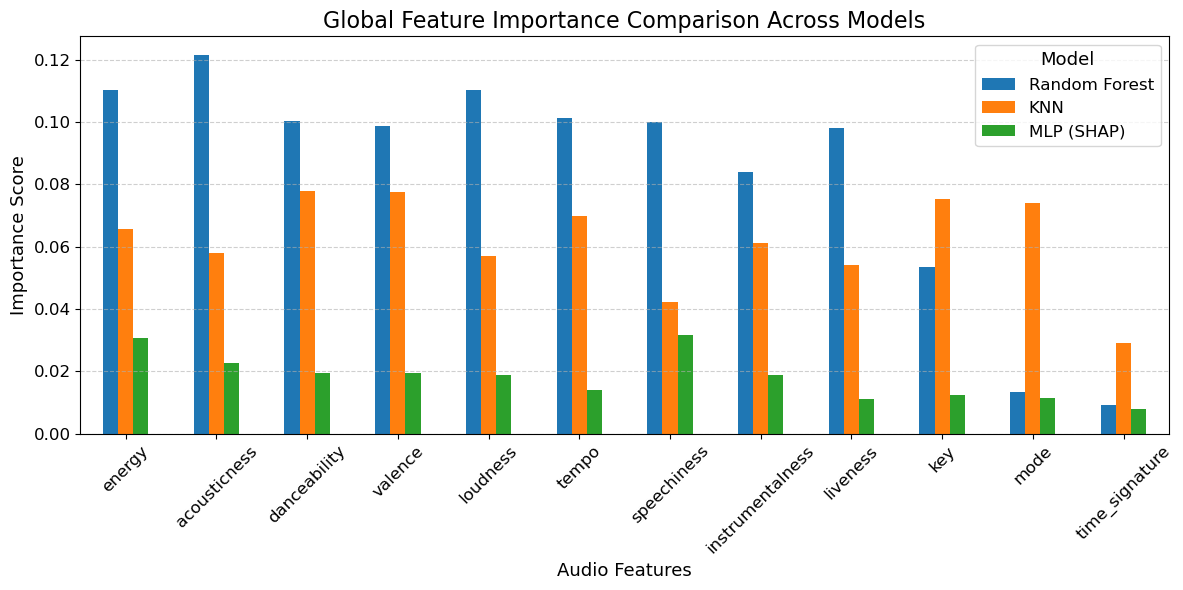

In [ ]:
# Rebuild global_df from existing importance dictionaries
global_df = pd.DataFrame({
    "Random Forest": rf_global_importance,
    "KNN": knn_global_importance,
    "MLP (SHAP)": mlp_global_importance
})

# Sort by average importance
global_df["Average"] = global_df.mean(axis=1)
global_df = global_df.sort_values("Average", ascending=False)
global_df = global_df.drop(columns="Average")

# Make folder if not exists
os.makedirs("Presentation/images", exist_ok=True)

# Plot with enlarged labels
ax = global_df.plot(kind="bar", figsize=(12, 6), rot=45)

plt.title("Global Feature Importance Comparison Across Models", fontsize=16)
plt.ylabel("Importance Score", fontsize=13)
plt.xlabel("Audio Features", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

legend = plt.legend(title="Model", fontsize=12, title_fontsize=13)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("Presentation/images/global_feature_importance_comparison.png", dpi=300)
plt.show()


In [ ]:
# Per Feature Importance Combine into one table
feature_importance_table = pd.DataFrame({
    "Feature": feature_cols,
    "Random Forest": [rf_global_importance[f] for f in feature_cols],
    "KNN": [knn_global_importance[f] for f in feature_cols],
    "MLP (SHAP)": [mlp_global_importance[f] for f in feature_cols]
})

# Sort by Random Forest (or any other model)
feature_importance_table = feature_importance_table.sort_values(by="Random Forest", ascending=False).reset_index(drop=True)

# Show table
print(feature_importance_table.round(4))


             Feature  Random Forest     KNN  MLP (SHAP)
0       acousticness         0.1214  0.0579      0.0227
1           loudness         0.1102  0.0571      0.0188
2             energy         0.1102  0.0655      0.0306
3              tempo         0.1012  0.0698      0.0139
4       danceability         0.1003  0.0780      0.0194
5        speechiness         0.1001  0.0421      0.0318
6            valence         0.0986  0.0777      0.0194
7           liveness         0.0980  0.0542      0.0110
8   instrumentalness         0.0839  0.0610      0.0190
9                key         0.0535  0.0754      0.0124
10              mode         0.0134  0.0742      0.0115
11    time_signature         0.0092  0.0290      0.0079


### Single Class Feature Importance

In [50]:
# Dict of per-label importance from multiple models
per_label_dicts = {
    "Random Forest": rf_per_label_importance,
    "KNN": knn_per_label_importance,
    "MLP (SHAP)": mlp_per_label_importance
}

# Output directory for CSVs
output_dir = "Presentation/tables/per_label"
os.makedirs(output_dir, exist_ok=True)

# Emotion labels
label_names = list(per_label_dicts["Random Forest"].keys())

# For each emotion label, generate importance table and save
for label in label_names:
    data = {}
    for model_name, label_dict in per_label_dicts.items():
        data[model_name] = label_dict[label]

    # Create DataFrame: rows = features, columns = models
    df = pd.DataFrame(data)
    
    # Sort by Random Forest importance
    df = df.sort_values(by="Random Forest", ascending=False)
    
    # Save as CSV
    csv_path = os.path.join(output_dir, f"{label}_feature_importance.csv")
    df.to_csv(csv_path)

    print(f"Saved table for label: {label} → {csv_path}")


Saved table for label: anger → Presentation/tables/per_label/anger_feature_importance.csv
Saved table for label: disgust → Presentation/tables/per_label/disgust_feature_importance.csv
Saved table for label: fear → Presentation/tables/per_label/fear_feature_importance.csv
Saved table for label: joy → Presentation/tables/per_label/joy_feature_importance.csv
Saved table for label: sadness → Presentation/tables/per_label/sadness_feature_importance.csv
Saved table for label: surprise → Presentation/tables/per_label/surprise_feature_importance.csv


In [40]:
import pandas as pd

# All models' per-label dictionaries
per_label_dicts = {
    "Random Forest": rf_per_label_importance,
    "KNN": knn_per_label_importance,
    "MLP (SHAP)": mlp_per_label_importance
}

# Collect rows in a list
rows = []

# Loop over each emotion
for label in per_label_dicts["Random Forest"].keys():
    features = per_label_dicts["Random Forest"][label].keys()
    for feature in features:
        row = {
            "Emotion": label,
            "Feature": feature,
            "Random Forest": per_label_dicts["Random Forest"][label][feature],
            "KNN": per_label_dicts["KNN"][label][feature],
            "MLP (SHAP)": per_label_dicts["MLP (SHAP)"][label][feature]
        }
        rows.append(row)

# Convert to DataFrame
importance_table = pd.DataFrame(rows)

# Optional: sort by Emotion then Random Forest importance descending
importance_table = importance_table.sort_values(by=["Emotion", "Random Forest"], ascending=[True, False])

# Save to CSV
importance_table.to_csv("Presentation/tables/all_models_per_label_importance.csv", index=False)

# More EDA

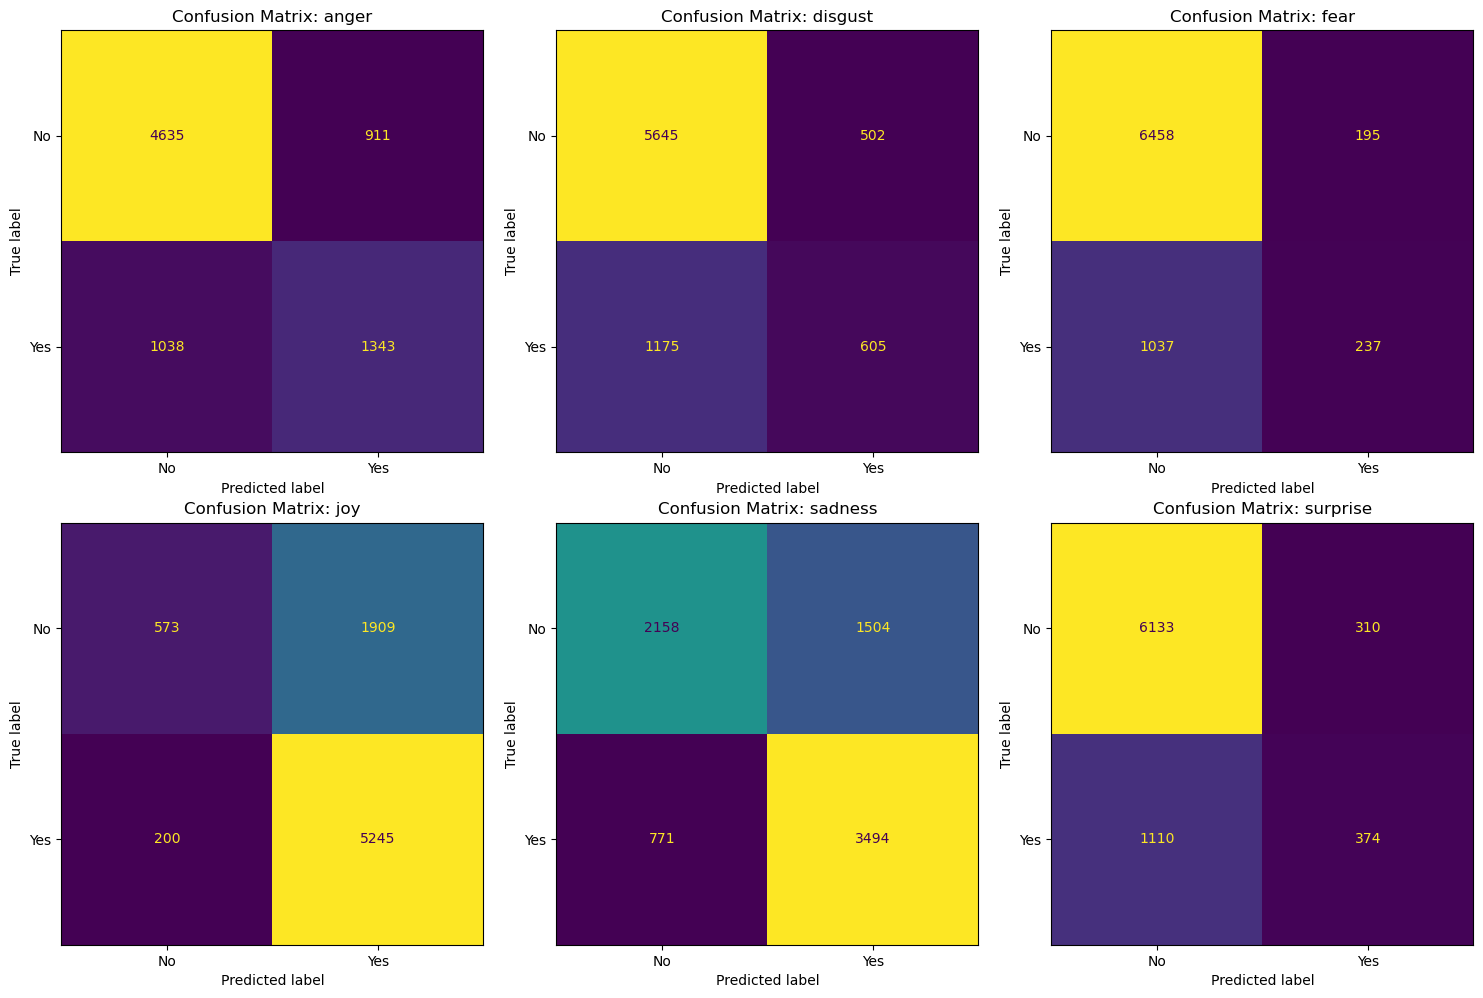

In [41]:
# Make sure y_test and y_pred are numpy arrays
y_true = np.array(y_test)
y_hat = np.array(y_pred)

# Plot confusion matrix for each label
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 6 emotions = 2 rows x 3 cols
axes = axes.ravel()

for idx, label in enumerate(mlb.classes_):
    cm = confusion_matrix(y_true[:, idx], y_hat[:, idx])
    disp = ConfusionMatrixDisplay(cm, display_labels=["No", "Yes"])
    disp.plot(ax=axes[idx], values_format='d', colorbar=False)
    axes[idx].set_title(f"Confusion Matrix: {label}")

plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


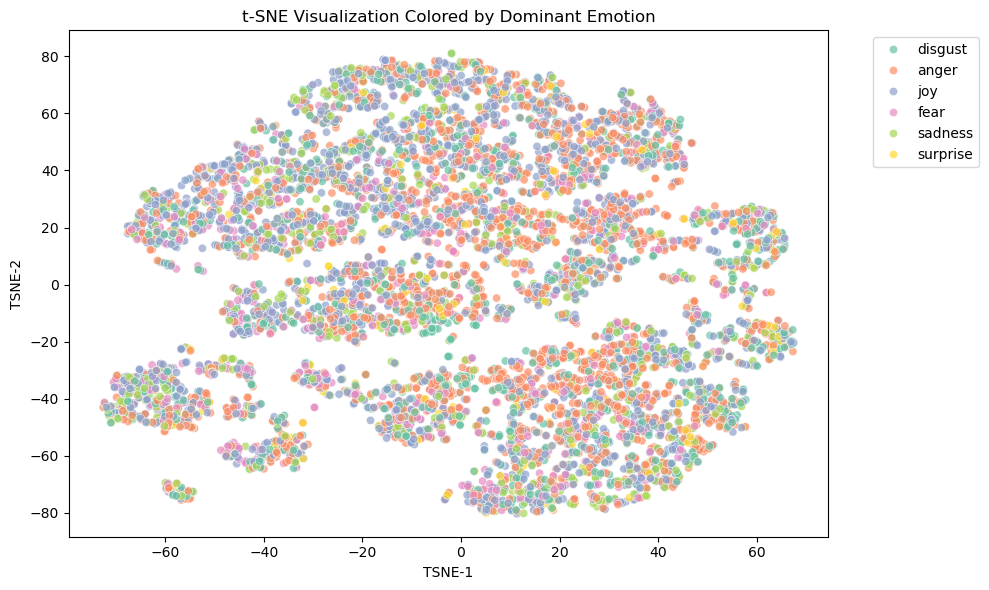

In [ ]:
from sklearn.manifold import TSNE

# Step 1: Reduce feature space with t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_test_scaled)

# Step 2: Get dominant emotion (first positive label)
dominant_emotion = [mlb.classes_[np.where(row == 1)[0][0]] if np.sum(row) > 0 else "none" for row in y_test]

# Step 3: Create DataFrame for plotting
tsne_df = pd.DataFrame({
    "TSNE-1": X_tsne[:, 0],
    "TSNE-2": X_tsne[:, 1],
    "Dominant Emotion": dominant_emotion
})

# Step 4: Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=tsne_df,
    x="TSNE-1", y="TSNE-2",
    hue="Dominant Emotion",
    palette="Set2",
    alpha=0.7
)
plt.title("t-SNE Visualization Colored by Dominant Emotion")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


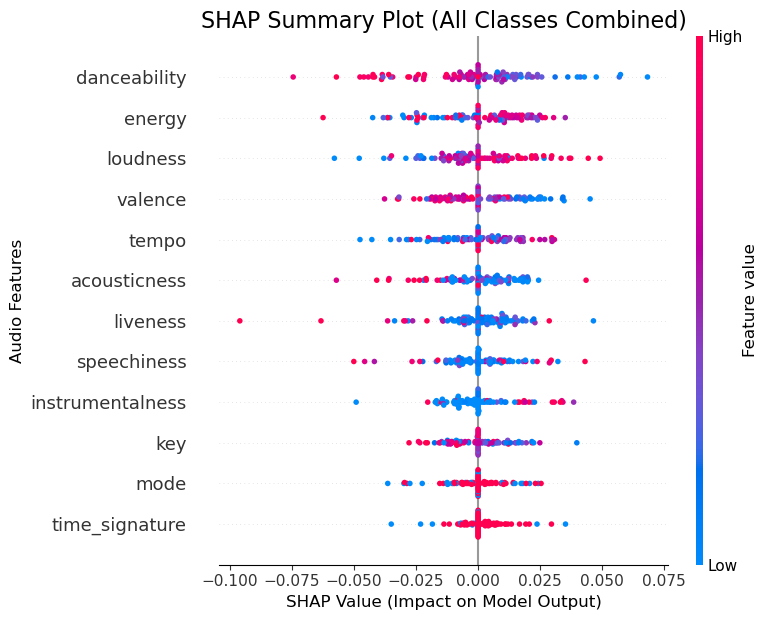

In [43]:
# Plot SHAP summary (dot = beeswarm) with color showing feature value
shap.summary_plot(
    shap_values,               # shape = (n_samples, n_features)
    X_sample,                  # corresponding feature matrix
    feature_names=feature_cols,
    plot_type="dot",           # default; shows color = feature value
    show=False                 # allows for custom labeling before show()
)

# Customize labels and title
plt.title("SHAP Summary Plot (All Classes Combined)", fontsize=16)
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
plt.ylabel("Audio Features", fontsize=12)
plt.tight_layout()

# Optional: Save figure
plt.savefig("Presentation/images/mlp_shap_summary_all.png", dpi=300)
plt.show()


# Ablation Study

### Remove PCA Dimensionality Reduction
In the main pipeline, PCA was optionally applied to reduce the dimensionality of standardized audio features before feeding them into the model. While PCA can help denoise and compress redundant features, it also removes interpretability, especially in feature importance and SHAP analysis.
In this ablation, we skip the PCA step entirely and evaluate the model on full 12-dimensional standardized features. The goal is to determine whether PCA offers measurable performance gain or if using the full raw feature space performs equally well (or better).
This also aligns with recent SHAP interpretability which requires original feature dimensions.

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score, hamming_loss, classification_report

# Re-standardize raw features (no PCA)
scaler_no_pca = StandardScaler()
X_train_no_pca = scaler_no_pca.fit_transform(X_train)
X_test_no_pca = scaler_no_pca.transform(X_test)

# Train same Random Forest without PCA
rf_no_pca = OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42))
rf_no_pca.fit(X_train_no_pca, y_train)

# Predict with dynamic Top-K
y_proba_no_pca = rf_no_pca.predict_proba(X_test_no_pca)
y_pred_no_pca = get_top_k_dynamic_predictions(y_proba_no_pca, y_test)

# Evaluate
print("==== Evaluation without PCA ====")
print("Micro F1:", f1_score(y_test, y_pred_no_pca, average="micro"))
print("Exact Match Accuracy:", accuracy_score(y_test, y_pred_no_pca))
print("Hamming Loss:", hamming_loss(y_test, y_pred_no_pca))
print(classification_report(y_test, y_pred_no_pca, target_names=mlb.classes_))


==== Evaluation without PCA ====
Micro F1: 0.6902399422695291
Exact Match Accuracy: 0.3876624195786552
Hamming Loss: 0.21660148858332282
              precision    recall  f1-score   support

       anger       0.61      0.59      0.60      2381
     disgust       0.57      0.36      0.44      1780
        fear       0.57      0.20      0.29      1274
         joy       0.74      0.97      0.84      5445
     sadness       0.71      0.83      0.77      4265
    surprise       0.58      0.26      0.36      1484

   micro avg       0.69      0.69      0.69     16629
   macro avg       0.63      0.53      0.55     16629
weighted avg       0.67      0.69      0.66     16629
 samples avg       0.61      0.61      0.61     16629



### Progressive Feature Dropping Based on Ranked Importance
In this ablation study, I examine how classification performance is affected as we remove less important features step-by-step.
I start from the top N most important features (as ranked by feature importance from a trained Random Forest model), then progressively drop the least important features one by one.
At each step, we train a new Random Forest classifier using only the remaining features, and evaluate it using cross-validated accuracy (3-fold).

This method can measure the marginal utility of each feature and identify whether model performance degrades significantly after removing certain features — helping to assess whether a smaller, more interpretable feature set could achieve similar results to the full feature set.

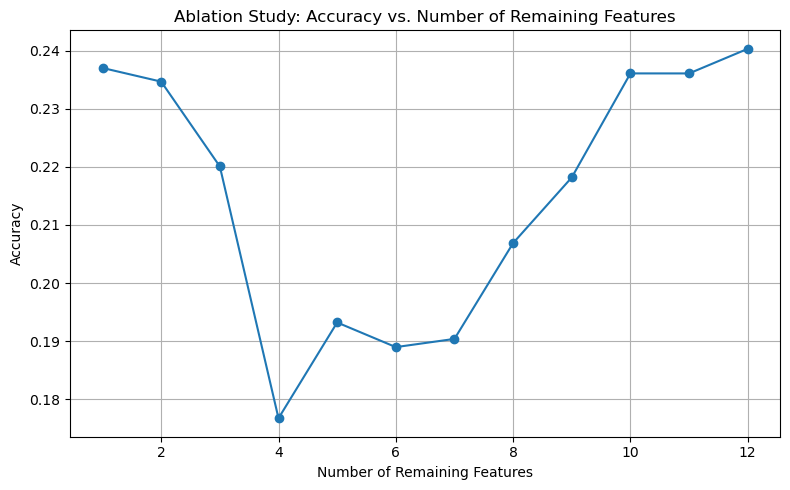

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

# Load your ablation results
ablation_df = pd.read_csv("ablation_results.csv")

# Sort by Remaining Features (optional)
ablation_df = ablation_df.sort_values("Remaining Features", ascending=False)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(
    ablation_df["Remaining Features"],
    ablation_df["Accuracy"],
    marker="o",
    linestyle="-"
)
plt.title("Ablation Study: Accuracy vs. Number of Remaining Features")
plt.xlabel("Number of Remaining Features")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

# Error Analysis & Model Interpretation

### Shared Misclassifications Across Models
To identify examples where all models systematically fail, we compare predictions from multiple classifiers and isolate the test samples where all models failed to correctly predict any of the true labels.
These shared misclassifications may reflect ambiguous data, multi-emotion songs, or limitations of the current feature set. Studying these examples can provide insights into the limits of model generalization and help guide dataset refinement or model redesign.

In [55]:
# Function to compute prediction with dynamic Top-K
def predict_with_topk(model, X, y_true):
    y_proba = model.predict_proba(X)
    return get_top_k_dynamic_predictions(y_proba, y_true)

# Compute predictions, Use non-PCA version of X_test
y_pred_rf = predict_with_topk(rf_model, X_test_no_pca, y_test)
y_pred_knn = predict_with_topk(knn_model, X_test_no_pca, y_test)
y_pred_mlp = predict_with_topk(mlp_model, X_test_no_pca, y_test)

# Convert to numpy arrays with proper type
y_pred_rf = np.array(y_pred_rf).astype(int)
y_pred_knn = np.array(y_pred_knn).astype(int)
y_pred_mlp = np.array(y_pred_mlp).astype(int)
y_true = np.array(y_test).astype(int)


# Create mask for correct predictions
correct_rf = (y_pred_rf & y_test).sum(axis=1) > 0
correct_knn = (y_pred_knn & y_test).sum(axis=1) > 0
correct_mlp = (y_pred_mlp & y_test).sum(axis=1) > 0

# Find shared error (all models wrong)
shared_error_mask = ~(correct_rf | correct_knn | correct_mlp)

# Apply mask to test set (you must have original df_full index aligned)
shared_error_indices = np.where(shared_error_mask)[0]
shared_error_samples = df_full.iloc[shared_error_indices][["title", "artist", "emotion"]]

# Display top 10 shared error songs
shared_error_samples.head(10)

,title,artist,emotion
3,Many Men (Wish Death),50 Cent,"[anger, fear, sadness, joy]"
13,Weary Blues,Louis Armstrong Hot Seven,[sadness]
20,Let Your Light Shine On Me,Blind Willie Johnson,"[sadness, joy]"
26,Nobody's Fault But Mine,Blind Willie Johnson,[sadness]
36,Never Gonna Dance,Fred Astaire,[joy]
45,All of Me,Billie Holiday_ Lester Young,"[anger, sadness, joy]"
67,Cross Road Blues,Robert Johnson,"[fear, sadness, joy]"
75,Traveling Riverside Blues,Robert Johnson,[sadness]
81,Nightmare,Artie Shaw & His Orchestra,[anger]
82,Moonlight Serenade,Glenn Miller Orchestra,"[fear, sadness, joy]"


### Per-Label(Emotion) Performance Heatmap
To identify which emotions are the most challenging to predict, we extract per-label F1-scores from the classification report and visualize them as a heatmap.
This allows us to quickly spot underperforming classes (e.g., fear, surprise), and guides further error analysis and data augmentation efforts.

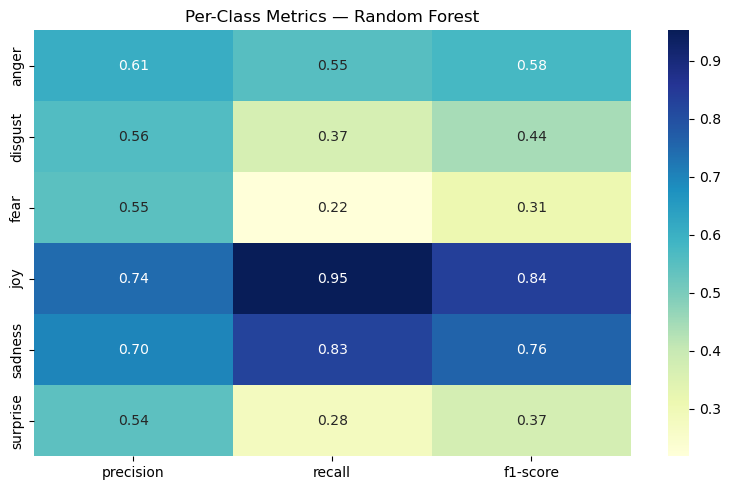

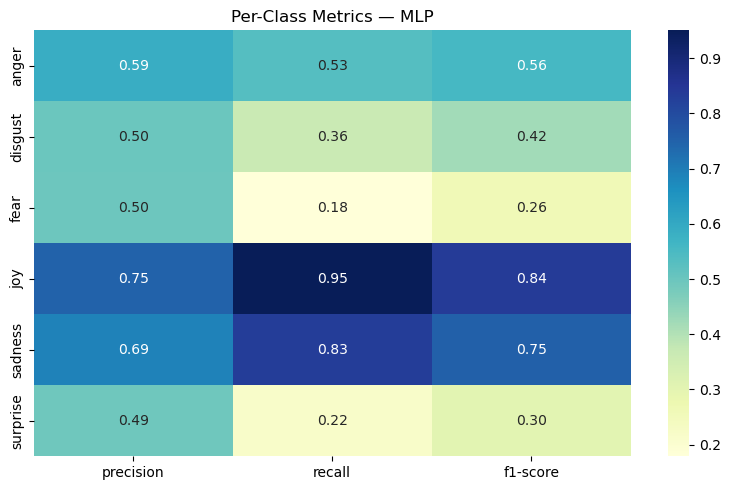

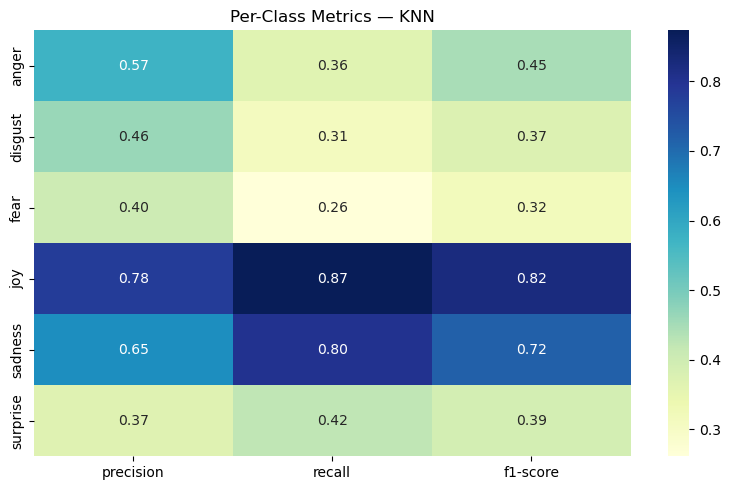

In [56]:
def plot_classification_heatmap(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, target_names=mlb.classes_, output_dict=True)
    report_df = pd.DataFrame(report).T
    class_metrics = report_df.loc[mlb.classes_, ["precision", "recall", "f1-score"]]

    plt.figure(figsize=(8, 5))
    sns.heatmap(class_metrics, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f"Per-Class Metrics — {model_name}")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_classification_heatmap(y_test, y_pred_rf, "Random Forest")
plot_classification_heatmap(y_test, y_pred_mlp, "MLP")
plot_classification_heatmap(y_test, y_pred_knn, "KNN")

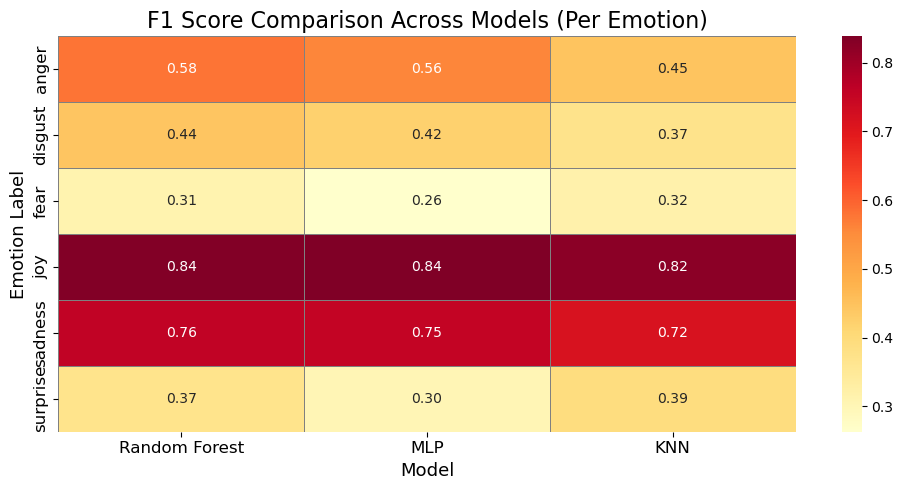

In [59]:
# F1 Score Comparison Per Emotion

# List of model predictions and names
models = {
    "Random Forest": y_pred_rf,
    "MLP": y_pred_mlp,
    "KNN": y_pred_knn
}

f1_table = pd.DataFrame()

for model_name, y_pred in models.items():
    report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)
    f1_scores = {label: report[label]["f1-score"] for label in mlb.classes_}
    f1_table[model_name] = pd.Series(f1_scores)

# Plot as heatmap with larger fonts
plt.figure(figsize=(10, 5))
ax = sns.heatmap(f1_table, annot=True, cmap="YlOrRd", fmt=".2f", linewidths=0.5, linecolor='gray')

plt.title("F1 Score Comparison Across Models (Per Emotion)", fontsize=16)
plt.xlabel("Model", fontsize=13)
plt.ylabel("Emotion Label", fontsize=13)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

plt.tight_layout()
plt.savefig("Presentation/images/f1_score_per_emotion.png", dpi=300)
plt.show()


### Label-wise Feature Distributions (TP vs FN)]
This analysis focuses on per-label performance. For each emotion, we split the test samples into:

True Positives (TP): samples where the label is present and correctly predicted

False Negatives (FN): samples where the label is present but not predicted

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure y_test and y_pred are numpy arrays
y_true = np.array(y_test).astype(int)
y_pred = np.array(y_pred_mlp).astype(int)  # Use your preferred model

# Use test indices to get back original features
X_test_df = df_full.iloc[test_indices].copy()  # test_indices from earlier split

# Define features to analyze
features_to_plot = ["valence", "acousticness", "energy", "instrumentalness"]

# For each label, create violin plots comparing TP vs FN for selected features
for label_idx, label in enumerate(mlb.classes_):
    # Get TP and FN mask for this label
    is_true = y_true[:, label_idx] == 1
    is_tp = (is_true) & (y_pred[:, label_idx] == 1)
    is_fn = (is_true) & (y_pred[:, label_idx] == 0)

    # Build DataFrame with error flag
    label_df = X_test_df[is_true].copy()
    label_df["Error Type"] = ["TP" if i else "FN" for i in is_tp[is_true]]

    # Plot
    fig, axes = plt.subplots(1, len(features_to_plot), figsize=(18, 4))
    for i, feature in enumerate(features_to_plot):
        sns.violinplot(
            data=label_df,
            x="Error Type",
            y=feature,
            palette="Set2",
            ax=axes[i]
        )
        axes[i].set_title(f"{label}: {feature}")

    plt.suptitle(f"{label.upper()} — Feature Distributions by Prediction Outcome", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


NameError: name 'test_indices' is not defined

### SHAP Analysis on Misclassified Samples

SHAP (SHapley Additive exPlanations) helps us interpret how each input feature contributed to a model’s prediction for a specific sample.
In this step, we apply SHAP to analyze songs where all models failed (shared errors). For each misclassified song, we compute SHAP values using the corresponding binary classifier inside the OneVsRestClassifier, and plot a force or waterfall chart to explain why the model failed to detect the correct emotion.
This helps uncover systematic misjudgments caused by misleading features or weak decision boundaries.

In [61]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (31708, 12)
X_test shape: (7927, 12)


  0%|          | 0/1 [00:00<?, ?it/s]

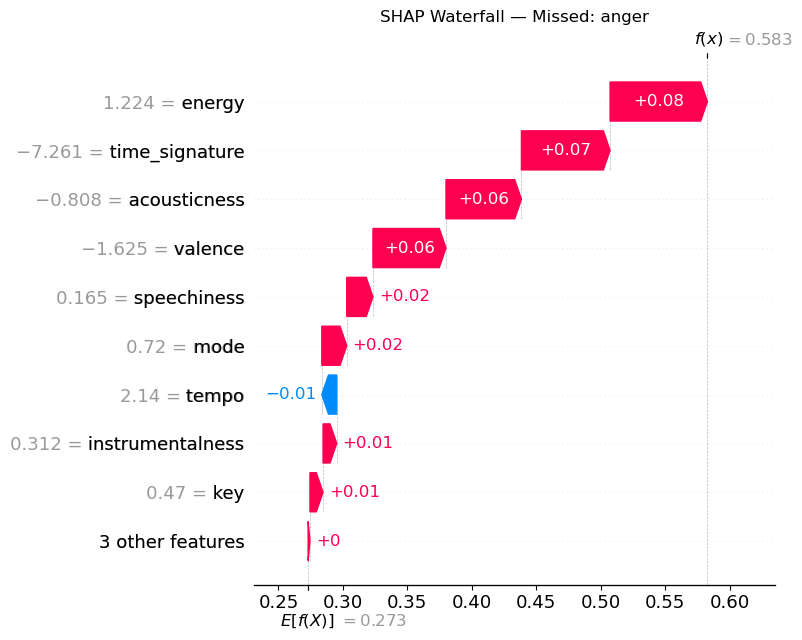

💾 Saved SHAP for anger to: Presentation/images/shap_missed_labels/anger_missed_shap_waterfall.png


  0%|          | 0/1 [00:00<?, ?it/s]

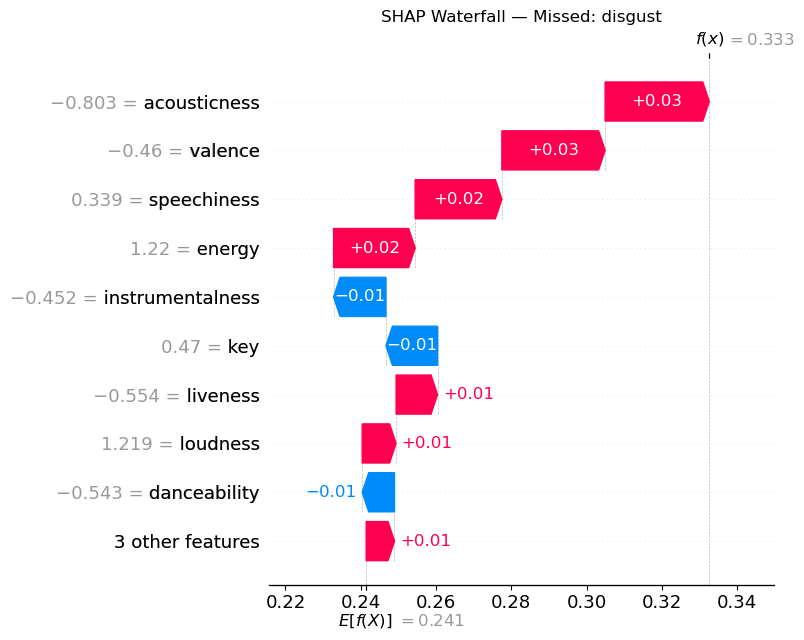

💾 Saved SHAP for disgust to: Presentation/images/shap_missed_labels/disgust_missed_shap_waterfall.png


  0%|          | 0/1 [00:00<?, ?it/s]

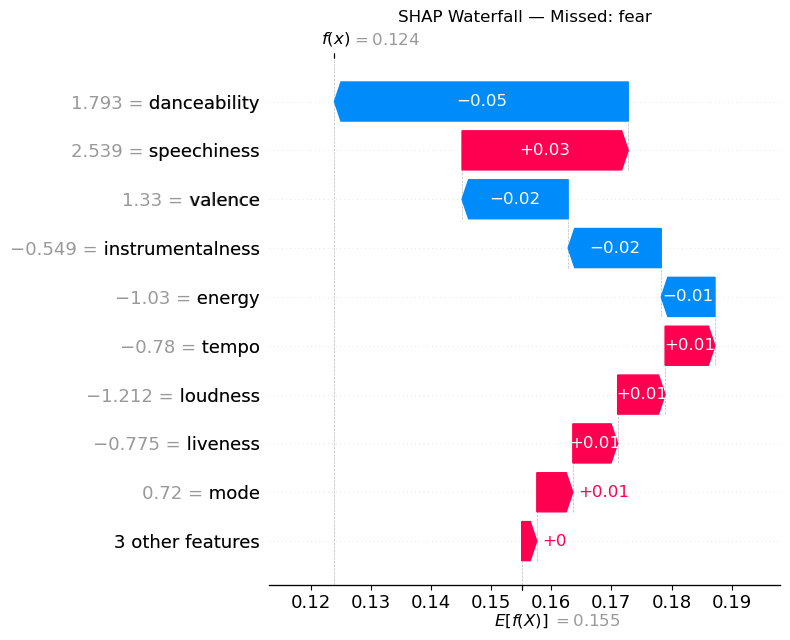

💾 Saved SHAP for fear to: Presentation/images/shap_missed_labels/fear_missed_shap_waterfall.png


  0%|          | 0/1 [00:00<?, ?it/s]

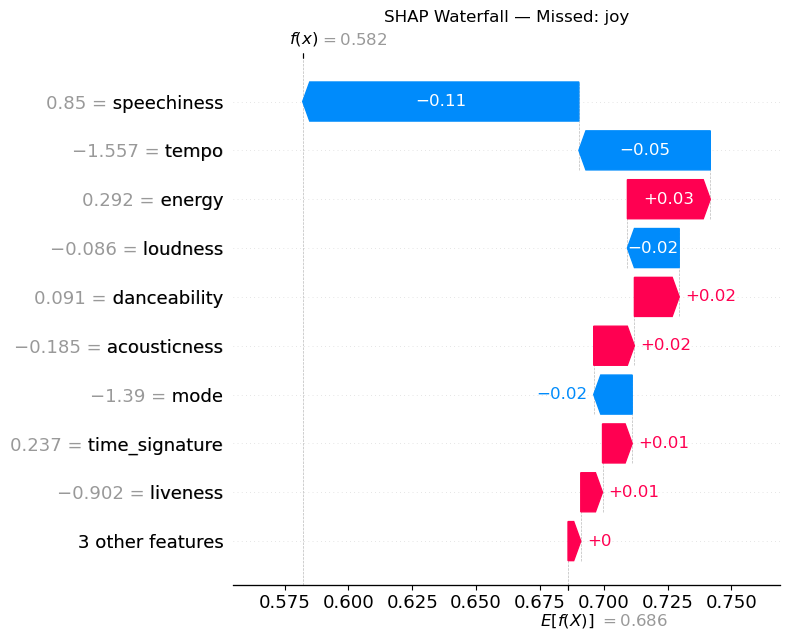

💾 Saved SHAP for joy to: Presentation/images/shap_missed_labels/joy_missed_shap_waterfall.png


  0%|          | 0/1 [00:00<?, ?it/s]

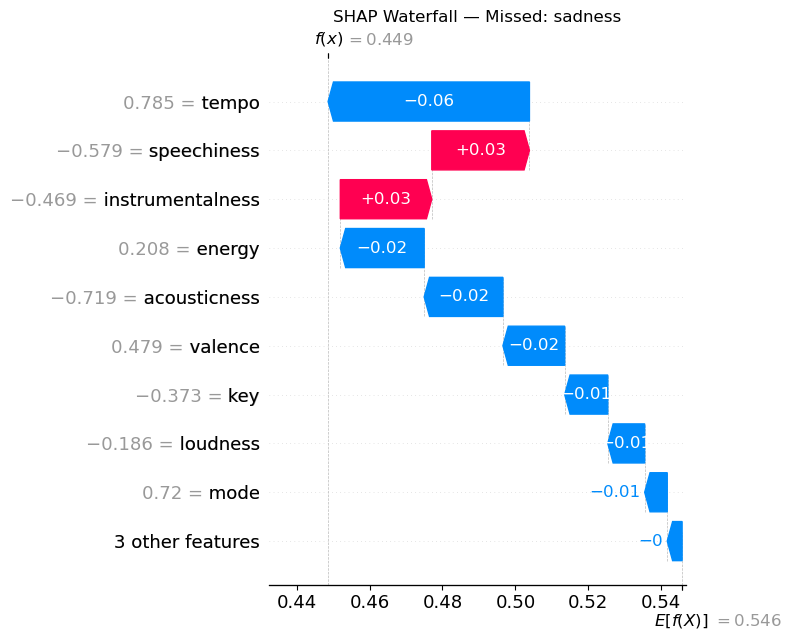

💾 Saved SHAP for sadness to: Presentation/images/shap_missed_labels/sadness_missed_shap_waterfall.png


  0%|          | 0/1 [00:00<?, ?it/s]

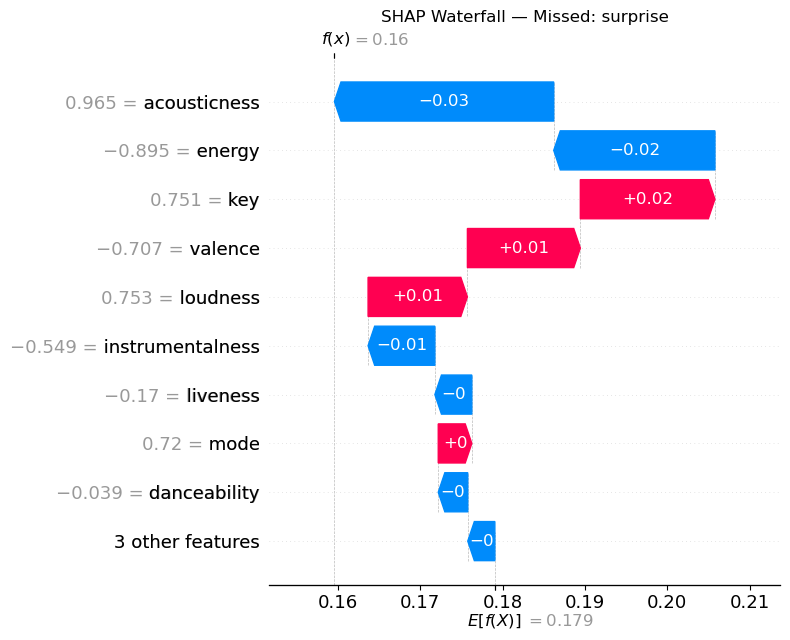

💾 Saved SHAP for surprise to: Presentation/images/shap_missed_labels/surprise_missed_shap_waterfall.png


In [62]:
import os
import shap
import matplotlib.pyplot as plt
import numpy as np

# Ensure output directory
output_dir = "Presentation/images/shap_missed_labels"
os.makedirs(output_dir, exist_ok=True)

# Prepare background
background = X_train_scaled_raw[:100]  # raw 12 features

# Loop through all emotion labels
for label_idx, label in enumerate(mlb.classes_):
    # Identify FN samples for this label
    true_mask = y_test[:, label_idx] == 1
    pred_mask = y_pred_mlp[:, label_idx] == 0
    fn_indices = np.where(true_mask & pred_mask)[0]

    if len(fn_indices) == 0:
        print(f"Skipping {label} (no FN)")
        continue

    # Choose one missed sample
    sample_idx = fn_indices[0]
    song_data = X_test_scaled_raw[sample_idx].reshape(1, -1)

    # Get binary model for this label
    model_i = mlp_model.estimators_[label_idx]

    def predict_fn(X):
        return model_i.predict_proba(X)[:, 1]

    # SHAP explanation
    explainer = shap.KernelExplainer(predict_fn, background)
    shap_values = explainer.shap_values(song_data, nsamples=100)

    # Plot and save
    fig = shap.plots.waterfall(shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=song_data[0],
        feature_names=feature_cols
    ), show=False)

    plt.title(f"SHAP Waterfall — Missed: {label}", fontsize=12)
    plt.tight_layout()
    path = f"{output_dir}/{label}_missed_shap_waterfall.png"
    plt.savefig(path, dpi=300)
    plt.show()
    plt.close()

    print(f"💾 Saved SHAP for {label} to: {path}")


### Emotion Co-occurrence vs. Prediction Error Rate
Some emotions may frequently co-occur with others, leading to label confusion or prediction difficulty.
In this analysis, we examine whether emotions that co-occur more often have higher misclassification rates.
For each label, we compute:

The average number of co-occurring labels in the test set when this emotion appears

The proportion of samples where the model failed to predict this label (i.e., False Negative rate)

This helps test the hypothesis that high label co-occurrence may correlate with higher confusion and recall drop.

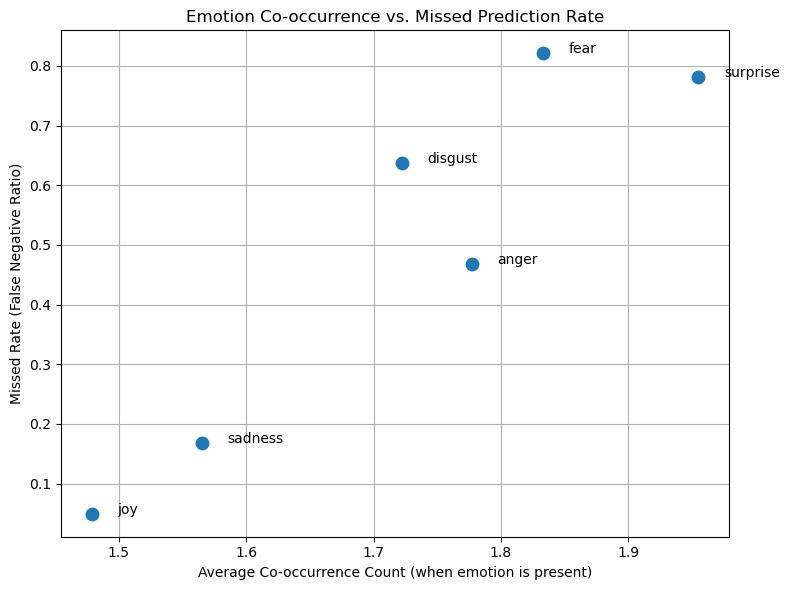

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Convert y_test and y_pred (from best model, e.g., MLP) to arrays
y_true = np.array(y_test)
y_hat = np.array(y_pred_mlp)

label_names = mlb.classes_
co_occurrence_counts = []
missed_rates = []

for i, label in enumerate(label_names):
    label_mask = y_true[:, i] == 1
    n_label = label_mask.sum()

    # 1. Average number of co-occurring labels (besides itself)
    total_co_labels = y_true[label_mask].sum(axis=1) - 1
    avg_co = total_co_labels.mean()

    # 2. Missed rate = proportion of samples where label was not predicted
    missed = (y_hat[:, i][label_mask] == 0).sum()
    missed_rate = missed / n_label if n_label > 0 else 0

    co_occurrence_counts.append(avg_co)
    missed_rates.append(missed_rate)

# Create dataframe
co_analysis_df = pd.DataFrame({
    "Emotion": label_names,
    "Avg Co-occurrence Count": co_occurrence_counts,
    "Missed Rate (FN Ratio)": missed_rates
}).sort_values("Avg Co-occurrence Count", ascending=False)

# Plot scatter
plt.figure(figsize=(8, 6))
plt.scatter(co_analysis_df["Avg Co-occurrence Count"], co_analysis_df["Missed Rate (FN Ratio)"], s=80)

# Annotate points
for _, row in co_analysis_df.iterrows():
    plt.text(row["Avg Co-occurrence Count"] + 0.02, row["Missed Rate (FN Ratio)"], row["Emotion"], fontsize=10)

plt.title("Emotion Co-occurrence vs. Missed Prediction Rate")
plt.xlabel("Average Co-occurrence Count (when emotion is present)")
plt.ylabel("Missed Rate (False Negative Ratio)")
plt.grid(True)
plt.tight_layout()
plt.show()

### In multilabel classification, models can mistakenly predict an incorrect label that was not present in the true set.
In this analysis, we compute a misclassification heatmap where the (i, j)-th cell counts how often emotion j was incorrectly predicted when emotion i was the true label.
This highlights common confusion pairs, such as sadness being mistaken as anger, or surprise being overpredicted due to co-occurrence patterns.

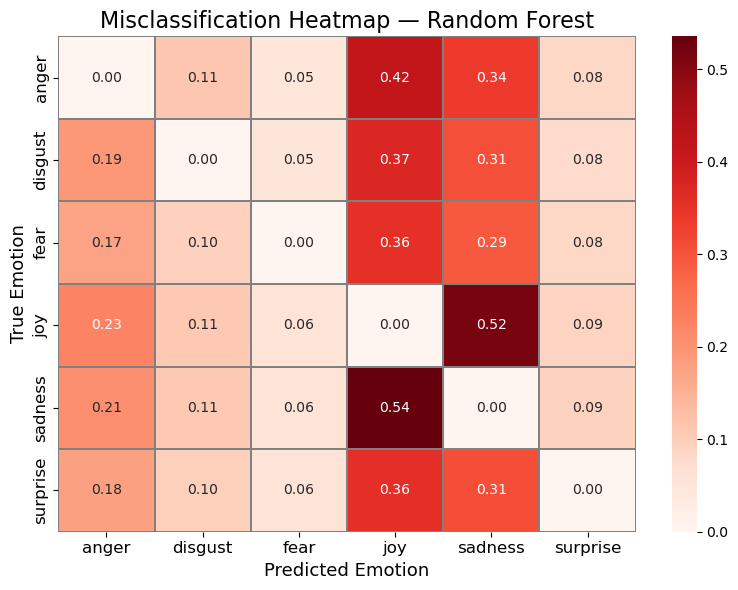

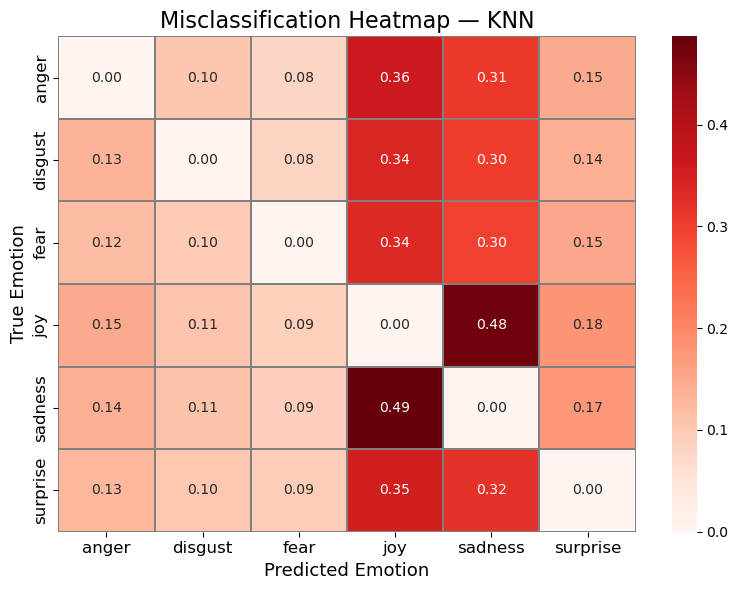

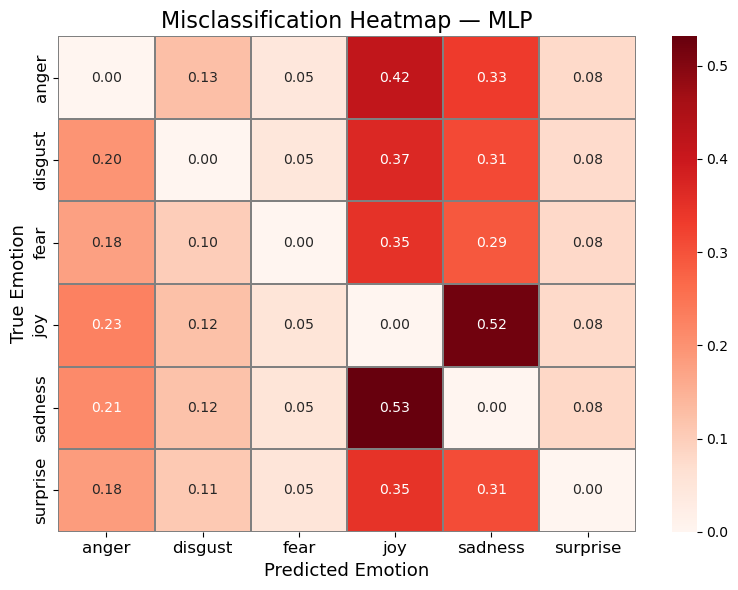

In [ ]:
# Ensure directory exists
os.makedirs("Presentation/images", exist_ok=True)

# Define model predictions in a dict
model_preds = {
    "Random Forest": y_pred_rf,
    "KNN": y_pred_knn,
    "MLP": y_pred_mlp
}

n_labels = y_test.shape[1]
label_names = mlb.classes_

# Function to compute and plot misclassification heatmap
def plot_misclassification_heatmap(y_true, y_pred, model_name):
    # Initialize confusion matrix
    conf_matrix = np.zeros((n_labels, n_labels), dtype=int)

    for true_row, pred_row in zip(y_true, y_pred):
        true_labels = np.where(true_row == 1)[0]
        pred_labels = np.where(pred_row == 1)[0]
        for i in true_labels:
            for j in pred_labels:
                if i != j:
                    conf_matrix[i, j] += 1

    # Create DataFrame
    conf_df = pd.DataFrame(conf_matrix, index=label_names, columns=label_names)
    conf_df_norm = conf_df.div(conf_df.sum(axis=1), axis=0)  # Normalize by row

    # Plot
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        conf_df_norm,
        annot=True,
        cmap="Reds",
        fmt=".2f", 
        linewidths=0.1,
        linecolor="gray"
    )

    ax.set_title(f"Misclassification Heatmap — {model_name}", fontsize=16)
    ax.set_xlabel("Predicted Emotion", fontsize=13)
    ax.set_ylabel("True Emotion", fontsize=13)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

    plt.tight_layout()
    plt.savefig(f"Presentation/images/misclassification_heatmap_{model_name.lower().replace(' ', '_')}.png", dpi=300)
    plt.show()

# Loop over models and plot
for name, y_pred in model_preds.items():
    plot_misclassification_heatmap(y_test, y_pred, name)
